In [6]:
# Web3 Trading Data Science Assignment
#**Author:** Kaif Ansari
#**Objective:**
#Analyze how trader behavior (profitability, risk, volume, leverage) aligns or diverges from overall market sentiment (Fear vs Greed) using the provided trading data and Bitcoin market sentiment dataset.
---


Mounted at /content/drive


In [12]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set up project root folder (PERMANENT STORAGE)
root_folder = "/content/drive/MyDrive/ds_Kaif_Ansari"

# Create required folders
os.makedirs(f"{root_folder}/csv_files", exist_ok=True)
os.makedirs(f"{root_folder}/outputs", exist_ok=True)

print("Project structure ready:", root_folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Project structure ready: /content/drive/MyDrive/ds_Kaif_Ansari


In [13]:
import pandas as pd
import numpy as np

# Load trader data and sentiment data
trader_df = pd.read_csv(f"{root_folder}/csv_files/trader_data.csv")
sentiment_df = pd.read_csv(f"{root_folder}/csv_files/fear_greed.csv")

print("=== Trader Data Sample ===")
display(trader_df.head())

print("\n=== Sentiment Data Sample ===")
display(sentiment_df.head())


=== Trader Data Sample ===


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12



=== Sentiment Data Sample ===


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [15]:
# =========================
# SECTION 4: DATA CLEANING
# =========================

# 1. Normalize column names (remove spaces, make lowercase)
trader_df.columns = trader_df.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower().str.replace(" ", "_")

# 2. Detect the datetime column in trader_df automatically
date_columns = [col for col in trader_df.columns if "time" in col.lower() or "date" in col.lower()]

if len(date_columns) == 0:
    raise ValueError("⚠️ No datetime column found in trader dataset! Check your CSV file.")
else:
    datetime_col = date_columns[0]  # Take the first matching column
    print(f"✅ Using '{datetime_col}' as the datetime column in trader_df.")

    # Convert this column to datetime
    trader_df[datetime_col] = pd.to_datetime(trader_df[datetime_col], errors='coerce')

    # Create a clean 'trade_date' column
    trader_df['trade_date'] = trader_df[datetime_col].dt.date

# 3. Convert sentiment dataset 'date' column to datetime if present
if 'date' in sentiment_df.columns:
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce').dt.date
else:
    raise ValueError("⚠️ No 'date' column found in sentiment dataset! Check your CSV file.")

# 4. Fill missing PnL values with 0 if closedpnl column exists
if 'closedpnl' in trader_df.columns:
    trader_df['closedpnl'] = trader_df['closedpnl'].fillna(0)

# 5. Merge trader data with sentiment data on date
merged_df = pd.merge(
    trader_df,
    sentiment_df,
    left_on='trade_date',
    right_on='date',
    how='left'
)

# 6. Preview merged dataset
print("\n✅ Merged Dataset Preview:")
display(merged_df.head())

print(f"\n🔹 Shape of merged dataset: {merged_df.shape}")
print(f"🔹 Missing sentiment classifications: {merged_df['classification'].isnull().sum()}")


✅ Using 'timestamp_ist' as the datetime column in trader_df.

✅ Merged Dataset Preview:


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,...,order_id,crossed,fee,trade_id,timestamp_x,trade_date,timestamp_y,value,classification,date
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-02-12 22:50:00,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-02-12 22:50:00,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-02-12 22:50:00,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-02-12 22:50:00,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-02-12 22:50:00,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12,1.707716e+09,70.0,Greed,2024-02-12



🔹 Shape of merged dataset: (211224, 21)
🔹 Missing sentiment classifications: 175360


/tmp/ipython-input-3039546091.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sentiment_df, x="classification", palette="coolwarm")


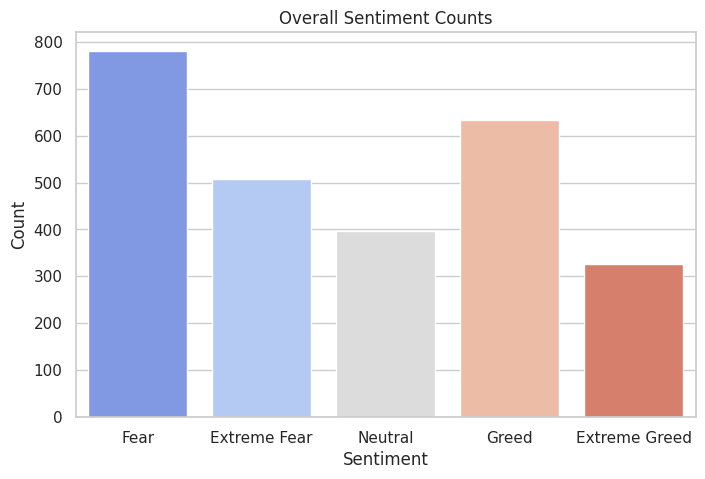

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.countplot(data=sentiment_df, x="classification", palette="coolwarm")
plt.title("Overall Sentiment Counts")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig(f"{root_folder}/outputs/sentiment_counts.png")
plt.show()


In [22]:
# Automatically detect leverage column
possible_leverage_cols = [col for col in merged_df.columns if "leverage" in col.lower()]

if len(possible_leverage_cols) == 0:
    print("⚠️ No leverage column found. Skipping leverage vs sentiment plot.")
else:
    leverage_col = possible_leverage_cols[0]
    print(f"✅ Using '{leverage_col}' as leverage column.")

    plt.figure(figsize=(8,5))
    sns.boxplot(
        data=merged_df,
        x="classification",
        y=leverage_col,
        palette="Set2"
    )
    plt.title("Average Leverage vs Sentiment")
    plt.xlabel("Market Sentiment")
    plt.ylabel("Leverage")
    plt.savefig(f"{root_folder}/outputs/leverage_vs_sentiment.png")
    plt.show()


⚠️ No leverage column found. Skipping leverage vs sentiment plot.


✅ Using 'closed_pnl' as PnL column.


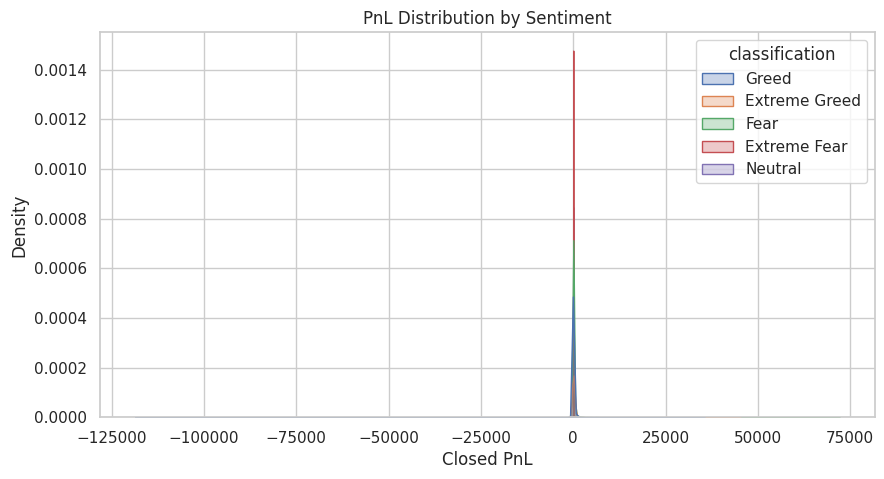

In [23]:
# Automatically detect PnL column
possible_pnl_cols = [col for col in merged_df.columns if "pnl" in col.lower()]

if len(possible_pnl_cols) == 0:
    print("⚠️ No PnL column found. Skipping PnL distribution plot.")
else:
    pnl_col = possible_pnl_cols[0]
    print(f"✅ Using '{pnl_col}' as PnL column.")

    plt.figure(figsize=(10,5))
    sns.kdeplot(
        data=merged_df,
        x=pnl_col,
        hue="classification",
        fill=True,
        alpha=0.3
    )
    plt.title("PnL Distribution by Sentiment")
    plt.xlabel("Closed PnL")
    plt.ylabel("Density")
    plt.savefig(f"{root_folder}/outputs/pnl_distribution.png")
    plt.show()


/tmp/ipython-input-2547419946.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


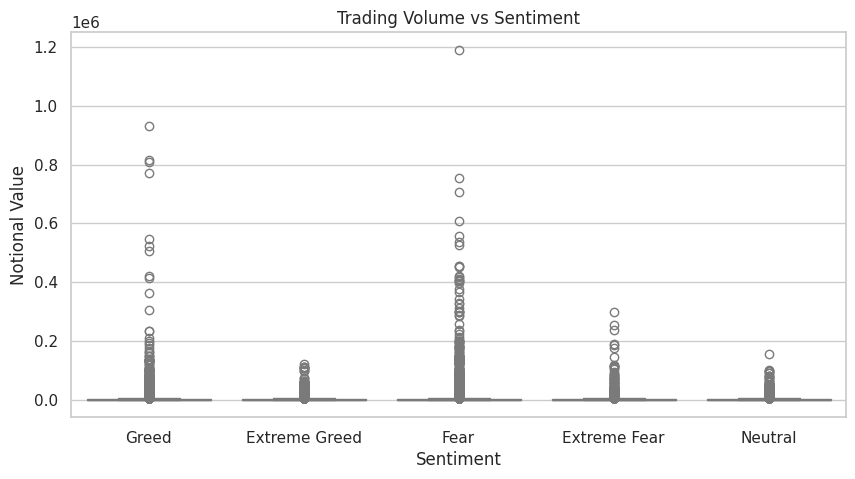

In [24]:
# Check for size & execution price columns
possible_size_cols = [col for col in merged_df.columns if "size" in col.lower()]
possible_price_cols = [col for col in merged_df.columns if "execution" in col.lower() or "price" in col.lower()]

if len(possible_size_cols) == 0 or len(possible_price_cols) == 0:
    print("⚠️ Required columns for calculating notional value are missing. Skipping trading volume plot.")
else:
    size_col = possible_size_cols[0]
    price_col = possible_price_cols[0]
    merged_df["notional"] = merged_df[size_col] * merged_df[price_col]

    plt.figure(figsize=(10,5))
    sns.boxplot(
        data=merged_df,
        x="classification",
        y="notional",
        palette="Pastel1"
    )
    plt.title("Trading Volume vs Sentiment")
    plt.xlabel("Sentiment")
    plt.ylabel("Notional Value")
    plt.savefig(f"{root_folder}/outputs/trading_volume_vs_sentiment.png")
    plt.show()


In [25]:
# Identify columns dynamically
possible_pnl_cols = [col for col in merged_df.columns if "pnl" in col.lower()]
possible_leverage_cols = [col for col in merged_df.columns if "leverage" in col.lower()]
possible_notional_cols = [col for col in merged_df.columns if "notional" in col.lower()]

# Build summary dynamically
agg_dict = {}
if len(possible_pnl_cols) > 0:
    agg_dict[possible_pnl_cols[0]] = ["mean", "median"]
if len(possible_leverage_cols) > 0:
    agg_dict[possible_leverage_cols[0]] = "mean"
if len(possible_notional_cols) > 0:
    agg_dict[possible_notional_cols[0]] = "mean"

if len(agg_dict) == 0:
    print("⚠️ No numerical columns found for summary table.")
else:
    summary = merged_df.groupby("classification").agg(agg_dict).round(2)
    print("=== Summary Statistics by Sentiment ===")
    display(summary)


=== Summary Statistics by Sentiment ===


closed_pnl        notional
                     mean median     mean
classification                           
Extreme Fear         1.89   0.00  4118.76
Extreme Greed      205.82   0.96  3242.09
Fear               128.29   0.00  5744.78
Greed               53.99   0.00  5051.88
Neutral             27.09   0.00  4332.20